Loading Data...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1430/84439471.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["w"] = df[VAR_WT] / 1000000.0
/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1430/84439471.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["is_registered"] = df[VAR_BIRTH_REG].isin([1, 2]).astype(int)



--- Summary Results ---
                   Percentage
Rwamagana                  85
Nyagatare                  73
Gatsibo                    82
Kayonza                    88
Kirehe                     88
Ngoma                      92
Bugesera                   86
East Province              84
Rwanda (National)          86

✅ JSON saved: eastern_Birth_Registration.json
✅ Plot saved: Birth_Registration_Only.png


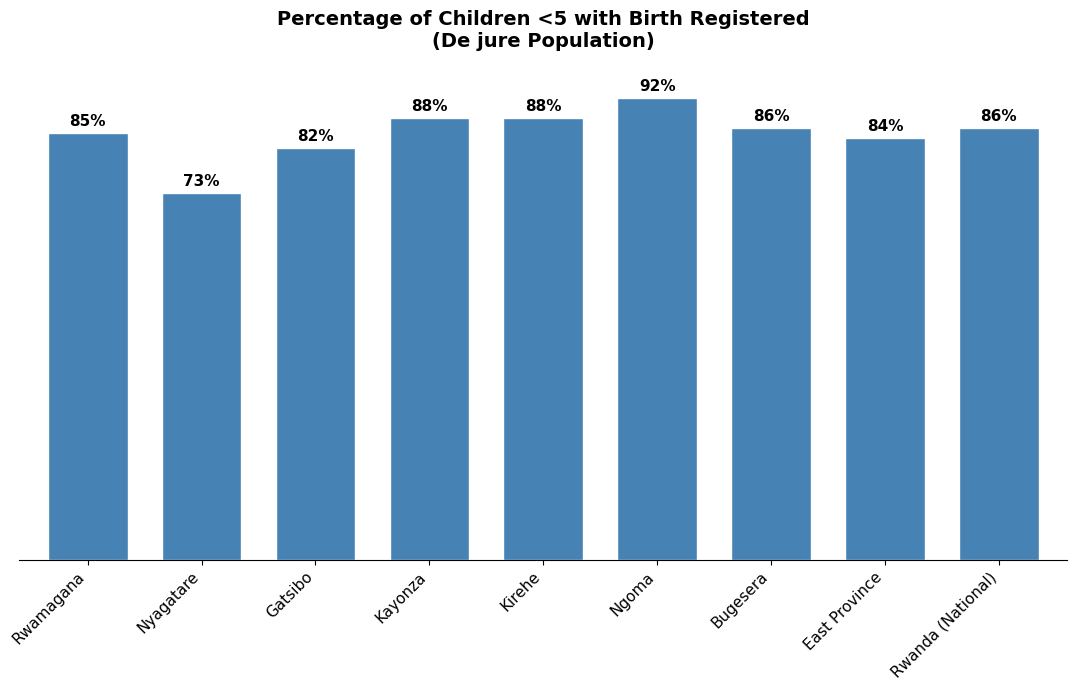

In [1]:
#!/usr/bin/env python3
# dhs_birth_registration_final.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
FILE_PATH = os.path.join("../data/RWPR81FL.DTA")

# Variable Map
VAR_WT       = "hv005"       # Weight
VAR_AGE      = "hv105"       # Age
VAR_RESIDENT = "hv102"       # Usual Resident (1=Yes) -> De jure
VAR_REG      = "hv024"       # Region
VAR_DIST     = "shdistrict"  # District (Ensure this exists in your specific dataset)
VAR_BIRTH_REG= "hv140"       # 1=Cert, 2=Reg, (0,8,9 = No)

DIST_MAP = {
    51: 'Rwamagana', 
    52: 'Nyagatare', 
    53: 'Gatsibo',
    54: 'Kayonza',
    55: 'Kirehe',
    56: 'Ngoma',
    57: 'Bugesera'
}

BAR_COLOR = "#4682B4"        # Steel Blue

# ------------------------------------------------------------------
# 2. ROUNDING & CALCULATION
# ------------------------------------------------------------------
def standard_round(n):
    """0.5 rounds UP to nearest Integer."""
    return int(math.floor(n + 0.5))

def get_registered_pct(df):
    """Calculates weighted % of children registered."""
    if df.empty or df['w'].sum() == 0:
        return 0
    # Weighted average * 100
    raw_pct = np.average(df['is_registered'], weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found.")
        exit()

    print("Loading Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FILTERS ---
    df = df[df[VAR_RESIDENT] == 1]  # De jure
    df = df[df[VAR_AGE] < 5]       # Under 5
    df["w"] = df[VAR_WT] / 1000000.0

    # --- DEFINE 'REGISTERED' VARIABLE ---
    # 1 (Has Certificate) OR 2 (Registered) = 1; else 0
    df["is_registered"] = df[VAR_BIRTH_REG].isin([1, 2]).astype(int)

    # --- CALCULATE ---
    results = []

    # A. District Level (East = Region 5)
    df_east = df[df[VAR_REG] == 5].copy()
    if VAR_DIST in df_east.columns:
        # Using include_groups=False to avoid future pandas warnings
        dist_stats = df_east.groupby(VAR_DIST).apply(
            lambda x: pd.Series({"Percentage": get_registered_pct(x)})
        )
        dist_stats.index = dist_stats.index.map(DIST_MAP)
        dist_stats = dist_stats[dist_stats.index.notnull()]
        results.append(dist_stats)

    # B. Province Level
    results.append(pd.DataFrame(
        {"Percentage": [get_registered_pct(df_east)]},
        index=["East Province"]
    ))

    # C. National Level
    results.append(pd.DataFrame(
        {"Percentage": [get_registered_pct(df)]},
        index=["Rwanda (National)"]
    ))

    # Combine
    final_df = pd.concat(results)
    print("\n--- Summary Results ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_filename = "eastern_Birth_Registration.json"
    output_dict = {
        "indicator": "Percentage of Children under 5 with Birth Certificate or Registered",
        "unit": "Percentage (%)",
        "population_type": "De jure Children < 5",
        # FIXED: Changed 'Val' to 'Percentage' to match the DataFrame
        "data": final_df['Percentage'].to_dict()
    }
    with open(json_filename, "w") as f:
        json.dump(output_dict, f, indent=4)
    print(f"\n✅ JSON saved: {json_filename}")

    # ------------------------------------------------------------------
    # 4. PLOTTING
    # ------------------------------------------------------------------
    ax = final_df.plot(kind="bar", legend=False, color=BAR_COLOR, figsize=(11, 7),
                       width=0.7, edgecolor="white")

    plt.title("Percentage of Children <5 with Birth Registered\n(De jure Population)", 
              fontsize=14, fontweight="bold", pad=20)
    
    # FIXED: Changed rotation to 45 for better readability of district names
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.xlabel("")
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    # Aesthetics
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)

    # Add Labels on top of bars
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', label_type="edge", padding=3,
                     fontsize=11, fontweight="bold", color="black")

    plt.tight_layout()
    plt.savefig("Birth_Registration_Only.png", dpi=300)
    print("✅ Plot saved: Birth_Registration_Only.png")